In [1]:
import sys
import os
import itertools
from tempfile import NamedTemporaryFile
from gc import collect
from time import time

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr

sys.path.append('../util')
from ncgen import make_nc
from meters import ThroughputMeter
from circle import wkt_circle
from geo import cartesian
from areas import metro_van_10, prov_bc_18, fp_270
from grids import bc_400m, canada_5k, world_125k, world_250k

from shapely import wkt
from shapely.geometry import Point


os.environ['TMPDIR'] = os.getenv('HOME') + '/tmp/'

In [2]:
def clipLatLonToPolyExtent(lat, lon, poly):
    minx, miny, maxx, maxy = poly.bounds    
    lat = lat[np.where( (lat > miny) & (lat < maxy) )]
    lon = lon[np.where( (lon > minx) & (lon < maxx) )]
    
    return lat, lon

def pointsInPoly(coords, poly):    
    x = [1 if Point(p[0], p[1]).within(poly) else 0 for p in coords]
    coords = coords[np.where(x)]
    return coords

In [3]:
def polygonToMask(nc, poly):
    # Grid method: http://erich.realtimerendering.com/ptinpoly/ should be tried

    nclats = nc.variables['lat'][:]
    nclons = nc.variables['lon'][:]

    mask = np.zeros(nc.variables['var_0'][0,:,:].shape)
    
    lat, lon = clipLatLonToPolyExtent(nclats, nclons, poly)
#     print(lat, lon)
    
    # If no centroids in polygon, return zeros
    if lat.size == 0 or lon.size == 0:
        return mask

#     print(lat, lon)
    coords = cartesian([lon, lat])
    pts = pointsInPoly(coords, poly)

    # map the lon, lat values back to numpy indices
    lons = np.sort(np.unique(pts[:,0]))
    lats = np.sort(np.unique(pts[:,1]))
    lon_indices = nclons.searchsorted(lons)
    lat_indices = nclats.searchsorted(lats)

    lat_map = dict(zip(lats, lat_indices))
    lon_map = dict(zip(lons, lon_indices))
    

    for pt in pts:
        mask[lon_map[pt[0]],lat_map[pt[1]]] = 1
        
    return mask

In [4]:
poly_complexity = [8, 16, 32, 64, 128]
grids = [world_250k, world_125k, canada_5k, bc_400m]


In [5]:
results = []

for grid in grids:
    with NamedTemporaryFile(suffix='.nc', delete=False, dir='/app/tmp') as f:
        nc = make_nc(f.name, grid=grid)
        
        # for sides in poly_complexity: #Circle generator doesn't seem to be working... circle centers near equator
        for area in metro_van_10, prov_bc_18, fp_270:
#           poly = wkt.loads(wkt_circle(sides))
            poly = wkt.loads(area)

            lat, lon = clipLatLonToPolyExtent(nc.variables['lat'][:], nc.variables['lon'][:], poly)
            if lat.size == 0 or lon.size == 0:
                pts_tested = 0
            else:
                pts_tested = len(cartesian([lon, lat]))
           
            t0 = time()
            mask = polygonToMask(nc, poly)
            t1 = time()
            t = t1 - t0

            r = (len(poly.exterior.coords), pts_tested, np.sum(mask), t)
            print(r)
            results.append(r)

(10, 0, 0.0, 0.00075531005859375)
(19, 0, 0.0, 0.0007698535919189453)
(271, 0, 0.0, 0.0007061958312988281)
(10, 0, 0.0, 0.0007505416870117188)
(19, 0, 0.0, 0.0006971359252929688)
(271, 0, 0.0, 0.0006906986236572266)
(10, 55, 41.0, 0.0050737857818603516)
(19, 34648, 20448.0, 1.690861463546753)
(271, 4128, 1562.0, 0.5342082977294922)
(10, 0, 0.0, 0.4136850833892822)
(19, 1386072, 821098.0, 67.65482068061829)
(271, 78566, 10807.0, 10.209963083267212)


In [6]:
results

[(10, 0, 0.0, 0.00075531005859375),
 (19, 0, 0.0, 0.0007698535919189453),
 (271, 0, 0.0, 0.0007061958312988281),
 (10, 0, 0.0, 0.0007505416870117188),
 (19, 0, 0.0, 0.0006971359252929688),
 (271, 0, 0.0, 0.0006906986236572266),
 (10, 55, 41.0, 0.0050737857818603516),
 (19, 34648, 20448.0, 1.690861463546753),
 (271, 4128, 1562.0, 0.5342082977294922),
 (10, 0, 0.0, 0.4136850833892822),
 (19, 1386072, 821098.0, 67.65482068061829),
 (271, 78566, 10807.0, 10.209963083267212)]

In [7]:
a = np.array([(r[1], r[3]) for r in results])
a

array([[  0.00000000e+00,   7.55310059e-04],
       [  0.00000000e+00,   7.69853592e-04],
       [  0.00000000e+00,   7.06195831e-04],
       [  0.00000000e+00,   7.50541687e-04],
       [  0.00000000e+00,   6.97135925e-04],
       [  0.00000000e+00,   6.90698624e-04],
       [  5.50000000e+01,   5.07378578e-03],
       [  3.46480000e+04,   1.69086146e+00],
       [  4.12800000e+03,   5.34208298e-01],
       [  0.00000000e+00,   4.13685083e-01],
       [  1.38607200e+06,   6.76548207e+01],
       [  7.85660000e+04,   1.02099631e+01]])

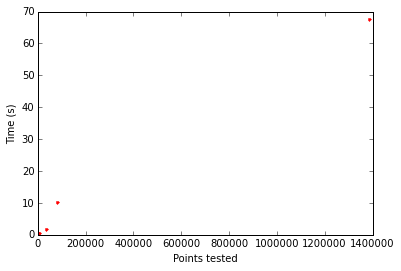

In [8]:
%matplotlib inline
plt.plot(a[:,0], a[:,1], 'r.', label="unlimited")
plt.xlabel('Points tested')
plt.ylabel('Time (s)')